In [10]:
import sys
sys.path.append("..")
from tools.CrossValidation import CrossValidation
from tools.DatasetBuilder import DatasetBuilder
from tools.params import dotdict
from tools.Baseline import Baseline

In [28]:
params = {
  "label_filename": "../../classification/train_png.txt",
  "data_folder": "/dataset/FIGURAS_ML_PUC_2019_Co/",

  "model": "vgg16",
  "batch": 64,
  "augmented": False,
  "n_folds": 10,
  "alpha": 1,
  "beta": 6,
  "width": None,
  "height": None,
  "n_classes": 3,
  "n_blocks": 4,
  "slice": 1.0,

  "rgb" : True,
  "normalize": True
}
params = dotdict( params )

In [17]:
data = DatasetBuilder( params.label_filename, params.data_folder, rgb = params.rgb,
		                            normalize = params.normalize, add_pos = False )
filename, labels = data.load_file( )
filename, _class = data.split( filename, labels, slice = params.slice )

Loading Classification File
------------------------------------------------
Original Classification File Summary

A Total of 5223 files.

Distribution
good    3364
bad     1745
ugly     114
Name: class, dtype: int64

Proportion
good    0.644074
bad     0.334099
ugly    0.021827
Name: class, dtype: float64

------------------------------------------------


In [29]:
width, height = data.get_shape( filename.iloc[0], params.beta, params.width, params.height )
images = data.load_images( filename, width = width, height = height, augmented = params.augmented )
labels = data.load_labels( _class )

- Processing folder /dataset/FIGURAS_ML_PUC_2019_Co/ :      sismoMod_Exp_00002869.png : 100%|██████████| 5223/5223 [05:01<00:00, 17.31it/s]


In [22]:
gpu_config = {
  "gpu": 0,
  "allow_growth": True,
  "gpu_memory": 1,
  "log_device_placement": False
}
gpu_config = dotdict( gpu_config )

c = CrossValidation (gpu_config)
model = c.get_model( params['model'] )

In [25]:
baseline = Baseline()
model_description, layers = baseline.build( model )

In [38]:
layer = layers[2]
values = baseline.extract_values(X=images, layer=layer)

- Processing image:   5223 / 5223


In [151]:
from sklearn.cluster import KMeans
kmeans = KMeans( random_state = 12345, n_clusters=3 ).fit( values )
print(kmeans.labels_)

[0 0 0 ... 0 0 0]


In [152]:
# Pegar os primeiros elementos de cada cluster
import numpy as np
qtd_cluster = len(kmeans.cluster_centers_)
index = [np.where(kmeans.labels_==x) for x in range(qtd_cluster)]
ind = [x[0][0] for x in index]
ind

[0, 1885, 3]

In [153]:
[[len(y) for y in x] for x in index]

[[4802], [1], [420]]

In [154]:
filename.values[ind]

array(['sismoMod_Exp_00002864.png', 'sismoMod_Exp_00003295.png',
       'sismoMod_Exp_00003978.png'], dtype=object)

In [155]:
import matplotlib.pyplot as plt
import os
path_to_classification = os.getcwd( ).rsplit( 'classificacao_sismo' )[0] + 'classificacao_sismo'

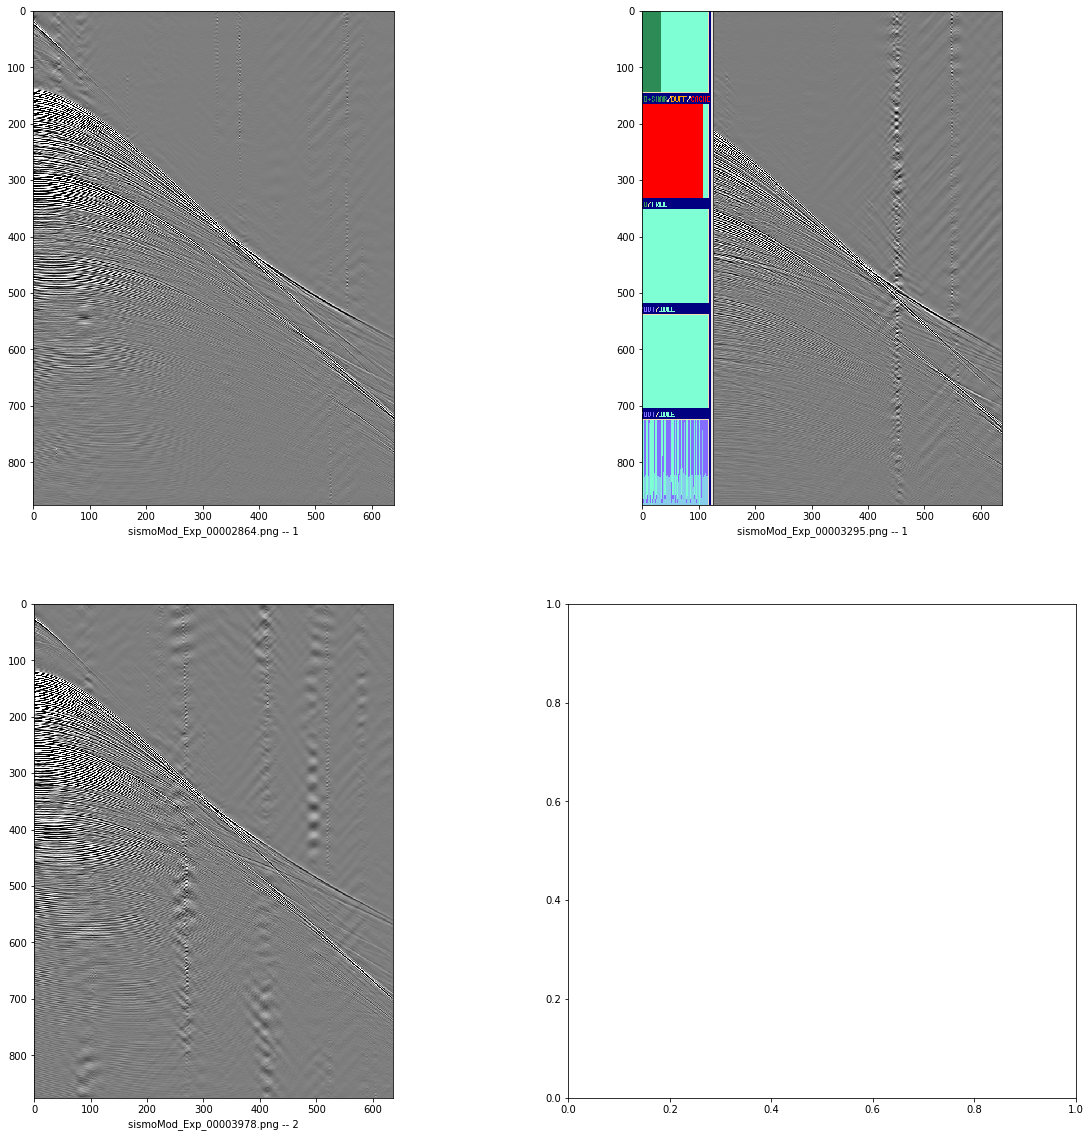

In [159]:
columns = 2
import math
f, ax = plt.subplots(math.ceil(len(index)/columns),columns, figsize=(20, 20))
for i, name in enumerate(filename.values[ind]):
    img = plt.imread(path_to_classification + params.data_folder + name)
    ax[int(i/columns),i %columns].imshow(img)
    ax[int(i/columns),i %columns].set_xlabel(name + ' -- ' + str(labels[ind][i]) )